Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 0.0547 - val_loss: 0.5187
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.0474 - val_loss: 0.5141
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0514 - val_loss: 0.5097
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0435 - val_loss: 0.5053
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0457 - val_loss: 0.5007
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0466 - val_loss: 0.4959
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0402 - val_loss: 0.4912
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0388 - val_loss: 0.4864
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0346 - val_loss: 0.4814
Epoch 10/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0369 - val_loss: 0.4762
Epoch 11/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0384 - val_loss: 0.4709
Epoch 12/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0359 - val_los

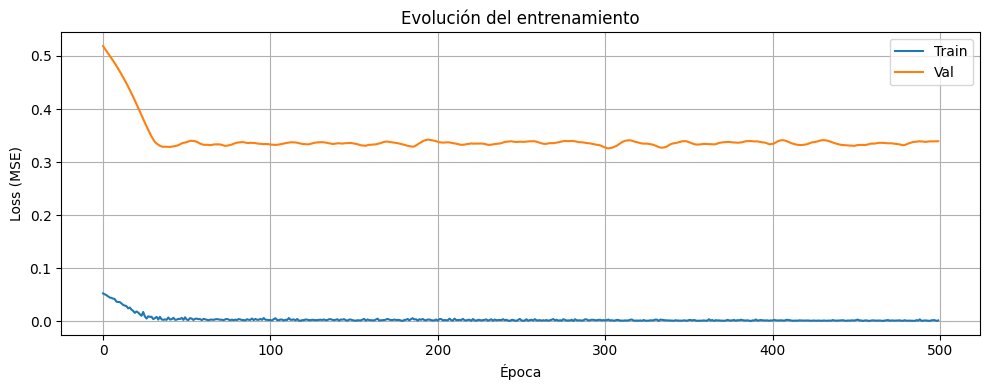


🧾 COMPARACIÓN DE PREDICCIONES VS MANUAL (2025-2029):
     Total activos (Manual)  Total activos (Predicción)  \
2025              133862159                  88822656.0   
2026              137644084                 101007088.0   
2027              142344032                  76942096.0   
2028              148184846                  76131528.0   
2029              155443458                  73317136.0   

     Total pasivos (Manual)  Total pasivos (Predicción)  \
2025               92735686                  67273712.0   
2026              112894727                  83475848.0   
2027              113895734                  54240412.0   
2028              115106398                  53390600.0   
2029              116578447                  49460800.0   

     Patrimonio de los accionistas (Manual)  \
2025                               22222537   
2026                               48603786   
2027                               81874483   
2028                              124165427   
2

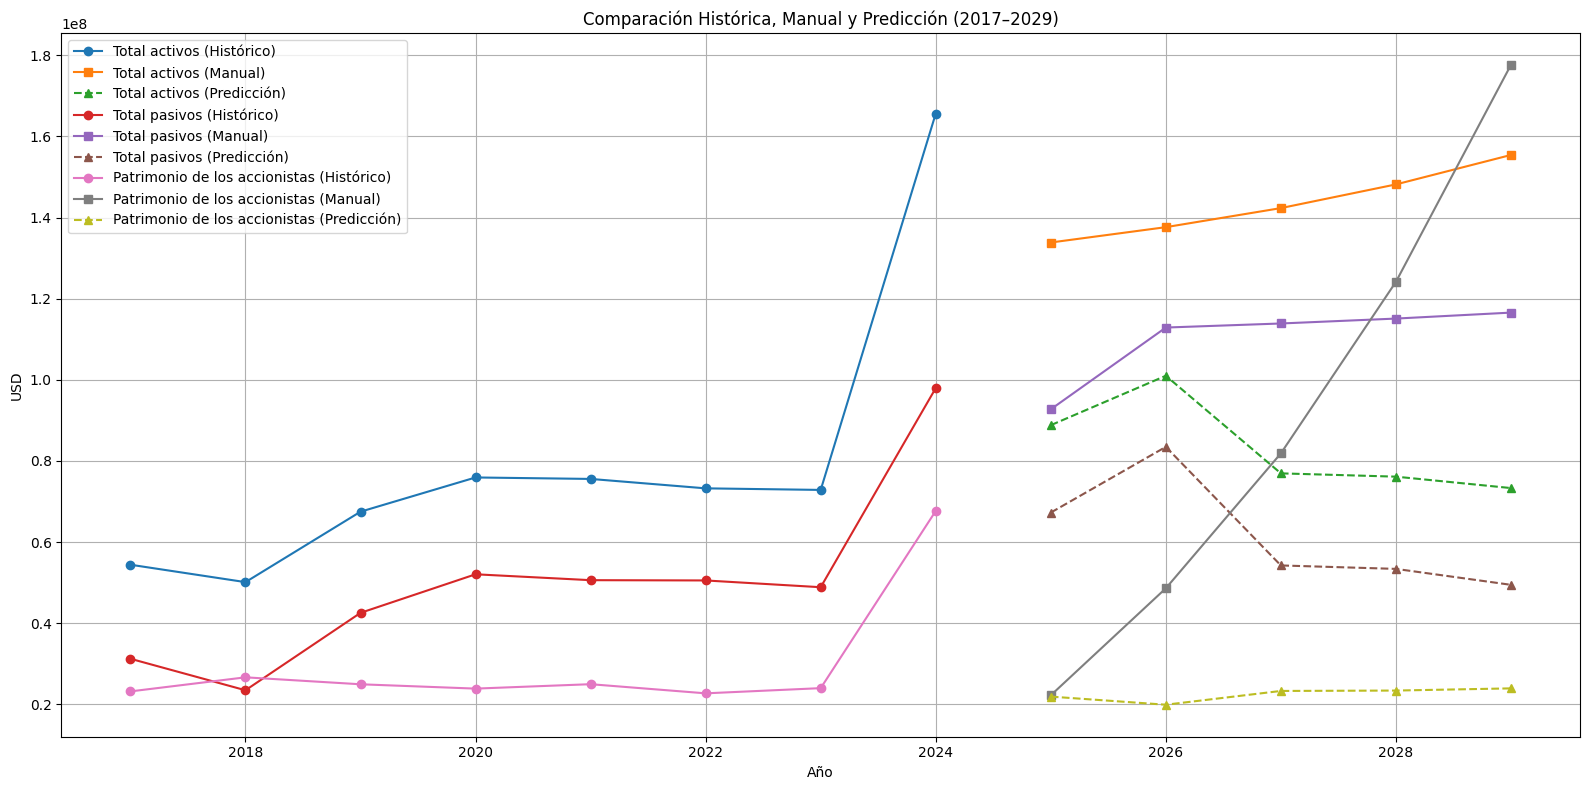

In [20]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import os
from sklearn.metrics import r2_score

# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# RUTAS A LOS ARCHIVOS (ajusta según tu Drive)
ruta_balance = '/content/drive/MyDrive/Colab Notebooks/AVGO_Balance_2017_2024.csv'
ruta_proyecciones = '/content/drive/MyDrive/Colab Notebooks/estado_situacion_financiera_proyecciones.csv'

# Verificar existencia de archivos
for ruta in [ruta_balance, ruta_proyecciones]:
    if not os.path.exists(ruta):
        print(f"❌ No se encuentra el archivo: {ruta}")
        exit(1)

# Leer datos históricos
df = pd.read_csv(ruta_balance, index_col=0)
df_transposed = df.T
df_transposed.index = df_transposed.index.astype(int)
df_transposed = df_transposed.sort_index()

metricas_objetivo = ['Total activos', 'Total pasivos', 'Patrimonio de los accionistas']
df_seleccionado = df_transposed[metricas_objetivo]

# Escalado
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_seleccionado)

# Crear secuencias para entrenamiento
def create_sequences(data, n_steps=2):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

n_steps = 2
X, y = create_sequences(scaled_data, n_steps)

# Modelo LSTM
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, X.shape[2])),
    Dropout(0.3),
    LSTM(25, activation='relu'),
    Dropout(0.3),
    Dense(X.shape[2])
])
model.compile(optimizer='adam', loss='mse')

# Entrenamiento
split_idx = int(len(X) * 0.8)
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=500,
                    verbose=1,
                    batch_size=2)

# Evaluación
print("📉 Evaluación del modelo:")
print(f"Entrenamiento loss: {model.evaluate(X_train, y_train, verbose=0):.6f}")
print(f"Validación loss: {model.evaluate(X_val, y_val, verbose=0):.6f}")

# Gráfica de entrenamiento
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Evolución del entrenamiento')
plt.xlabel('Época')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Predicción 2025–2029
last_sequence = scaled_data[-n_steps:]
predictions = []
for i in range(5):
    pred = model.predict(last_sequence.reshape(1, n_steps, X.shape[2]), verbose=0)
    predictions.append(pred[0])
    last_sequence = np.append(last_sequence[1:], pred, axis=0)

predicted_data = scaler.inverse_transform(np.array(predictions))
predicted_df = pd.DataFrame(predicted_data, columns=metricas_objetivo, index=range(2025, 2030))

# Leer proyecciones manuales
df_manual = pd.read_csv(ruta_proyecciones, index_col=0).T
df_manual.index = df_manual.index.astype(int)

mapeo_columnas = {
    'TOTAL ACTIVOS/': 'Total activos',
    'Total Pasivos/': 'Total pasivos',
    'Total Patrimonio/': 'Patrimonio de los accionistas'
}

comparacion_df = pd.DataFrame()
for col_manual, col_pred in mapeo_columnas.items():
    if col_manual in df_manual.columns:
        comparacion_df[f'{col_pred} (Manual)'] = df_manual[col_manual]
        comparacion_df[f'{col_pred} (Predicción)'] = predicted_df[col_pred]

comparacion_df = comparacion_df.loc[2025:2029]

# Mostrar tabla de comparación
print("\n🧾 COMPARACIÓN DE PREDICCIONES VS MANUAL (2025-2029):")
print(comparacion_df.round(0))

# Análisis de diferencias
print("\n📊 DIFERENCIAS EN 2029:")
for metrica in metricas_objetivo:
    col_m, col_p = f'{metrica} (Manual)', f'{metrica} (Predicción)'
    if col_m in comparacion_df.columns:
        m_val, p_val = comparacion_df.loc[2029, col_m], comparacion_df.loc[2029, col_p]
        diff = p_val - m_val
        pct = (diff / m_val) * 100
        print(f"\n{metrica.upper()}:")
        print(f"  Manual: {m_val:,.0f}")
        print(f"  Predicción: {p_val:,.0f}")
        print(f"  Diferencia: {diff:,.0f} ({pct:+.1f}%)")

# Gráfica final
plt.figure(figsize=(16, 8))
for metrica, color in zip(metricas_objetivo, ['blue', 'red', 'green']):
    plt.plot(df_seleccionado.index, df_seleccionado[metrica],
             label=f'{metrica} (Histórico)', marker='o')
    if f'{metrica} (Manual)' in comparacion_df:
        plt.plot(comparacion_df.index, comparacion_df[f'{metrica} (Manual)'],
                 label=f'{metrica} (Manual)', marker='s')
    plt.plot(predicted_df.index, predicted_df[metrica],
             label=f'{metrica} (Predicción)', linestyle='--', marker='^')

plt.title('Comparación Histórica, Manual y Predicción (2017–2029)')
plt.xlabel('Año')
plt.ylabel('USD')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


=== PREDICCIÓN DE ESTADOS DE RESULTADOS CON LSTM ===

Datos históricos disponibles (ordenados correctamente):
Año   Ingresos  Costo de Ventas  Utilidad Bruta  Gastos de I+D  Gastos SG&A  \
2017  17636000          9127000         8509000        3302000       789000   
2018  20848000         10115000        10733000        3768000      1056000   
2019  22597000         10114000        12483000        4696000      1709000   
2020  23888000         10372000        13516000        4968000      1935000   
2021  27450000         10606000        16844000        4854000      1347000   
2022  33203000         11108000        22095000        4919000      1382000   
2023  35819000         11129000        24690000        5253000      1592000   
2024  51574000         19065000        32509000        9310000      4959000   

Año   Otros Ingresos/Gastos Operativos  Gastos Operativos  Utilidad Operativa  \
2017                                 0            6138000             2371000   
2018            

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Predicciones LSTM 2025-2029: [51574000. 51574000. 51574000. 51574000. 51574000.]
Rango histórico: 17,636,000 - 51,574,000

--- Entrenando Utilidad Bruta ---
Datos históricos Utilidad Bruta (2017-2024): [ 8509000 10733000 12483000 13516000 16844000 22095000 24690000 32509000]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Predicciones LSTM 2025-2029: [32509000. 32509000. 32509000. 32509000. 32509000.]
Rango histórico: 8,509,000 - 32,509,000

--- Entrenando Utilidad Operativa ---
Datos históricos Utilidad Operativa (2017-2024): [ 2371000  5135000  3444000  4014000  8519000 14225000 16207000 13463000]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Predicciones LSTM 2025-2029: [11090161. 13311712. 15993471. 15580586. 13316827.]
Rango histórico: 2,371,000 - 16,207,000

--- Entrenando Utilidad Antes de Impuestos ---
Datos históricos Utilidad Antes de Impuestos (2017-2024): [ 1825000  4545000  2226000  2443000  6765000 12434000 15097000  9916000]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Predicciones LSTM 2025-2029: [ 8010360.5  5545308.5  8749619.  12073947.  13130709. ]
Rango histórico: 1,825,000 - 15,097,000

--- Entrenando Utilidad Neta ---
Datos históricos Utilidad Neta (2017-2024): [ 1784000 12259000  2695000  2663000  6437000 11223000 14082000  5895000]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Predicciones LSTM 2025-2029: [ 7847905.   6157187.5  7369652.   9700037.  10065729. ]
Rango histórico: 1,784,000 - 14,082,000

Columnas en proyecciones manuales:
  - Ingresos de actividades ordinarias
  - Costos de ventas
  - Ganancia (pérdida) bruta
  - Gastos de ventas y distribución y Gastos de administración
  - Gastos operativos
  - Ganancia (pérdida) operativa
  - Gastos de depreciación y amortización
  - (Gasto) por impuesto a la renta
  - Flujo de caja bruto
  - Inversiones en activos fijos neto
  - Variaciones en capital de trabajo
  - Flujo de caja libre (FCF)
  - Ingresos totales
  - Costo de ingresos
  - Utilidad bruta
  - Gastos Operativos
  - Utilidad Operativa
  - Gastos Financieros
  - Utilidad antes de impuestos
  - Impuesto a la renta
  - Utilidad Neta

Graficando Ingresos vs Ingresos de actividades ordinarias

Graficando Utilidad Bruta vs Ganancia (pérdida) bruta

Graficando Utilidad Operativa vs Ganancia (pérdida) operativa

Graficando Utilidad Antes de Impuestos vs

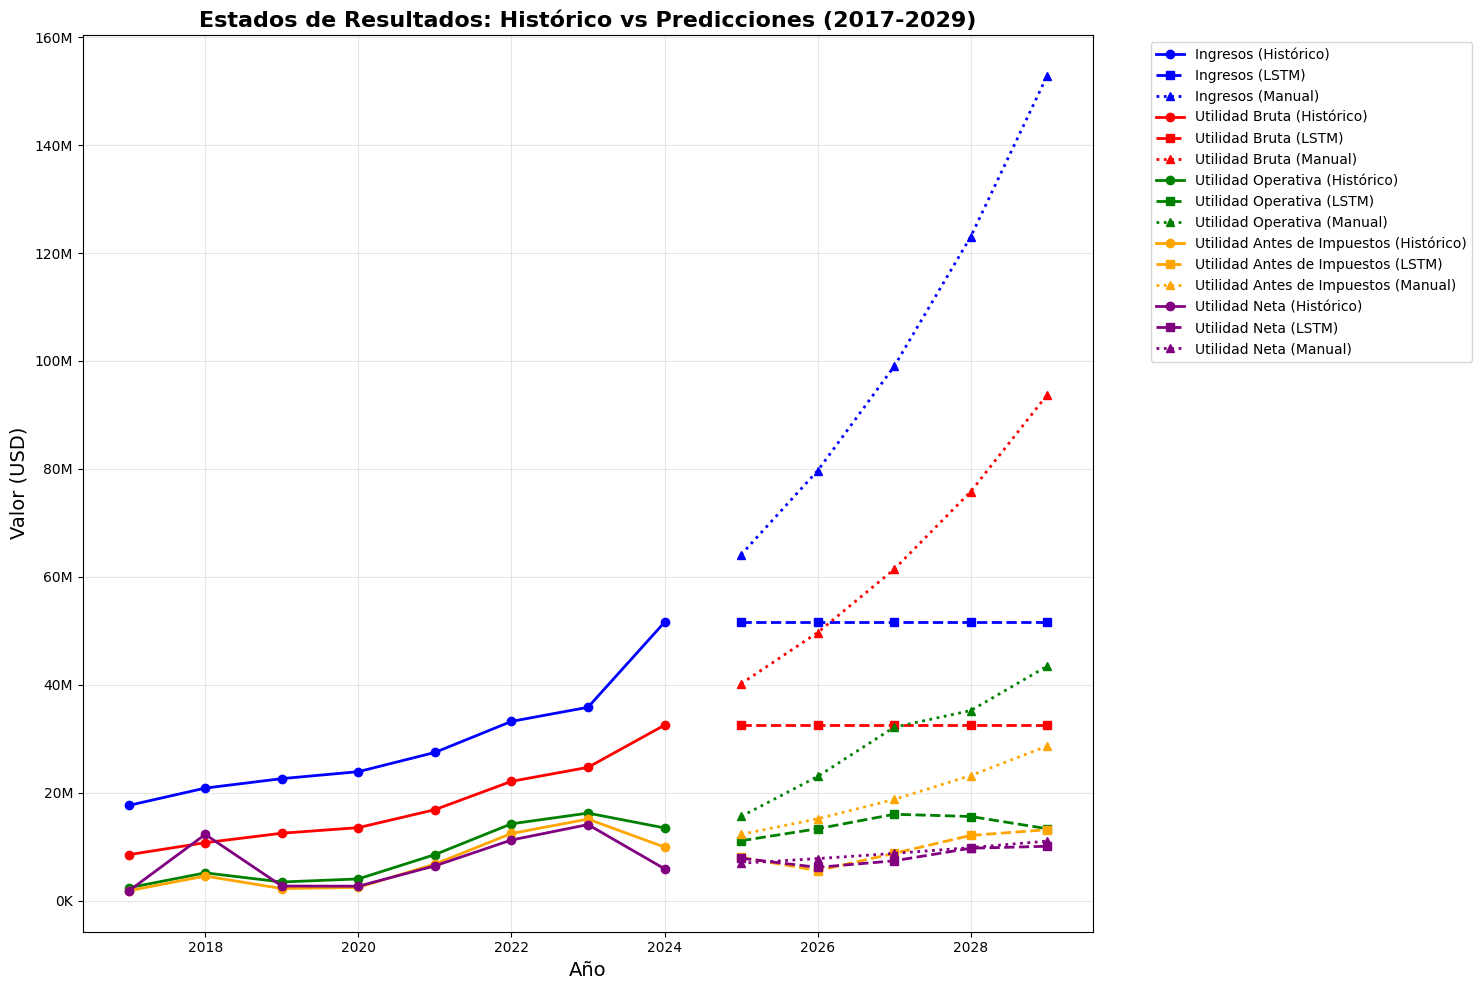


COMPARACIÓN: LSTM vs PROYECCIONES MANUALES

INGRESOS:
Histórico (2017-2024): [17636000 20848000 22597000 23888000 27450000 33203000 35819000 51574000]
LSTM (2025-2029): [51574000. 51574000. 51574000. 51574000. 51574000.]
Manual (2025-2029): [6.409300e+07 7.965100e+07 9.898574e+07 1.230132e+08 1.528734e+08]
Diferencias (LSTM - Manual): [-1.251900e+07 -2.807700e+07 -4.741174e+07 -7.143920e+07 -1.012994e+08]
  2025: LSTM=$51,574,000 vs Manual=$64,093,000 (Diff: $-12,519,000, -19.5%)
  2026: LSTM=$51,574,000 vs Manual=$79,651,000 (Diff: $-28,077,000, -35.3%)
  2027: LSTM=$51,574,000 vs Manual=$98,985,740 (Diff: $-47,411,740, -47.9%)
  2028: LSTM=$51,574,000 vs Manual=$123,013,200 (Diff: $-71,439,200, -58.1%)
  2029: LSTM=$51,574,000 vs Manual=$152,873,400 (Diff: $-101,299,400, -66.3%)

UTILIDAD BRUTA:
Histórico (2017-2024): [ 8509000 10733000 12483000 13516000 16844000 22095000 24690000 32509000]
LSTM (2025-2029): [32509000. 32509000. 32509000. 32509000. 32509000.]
Manual (2025-2029): [40

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

print("=== PREDICCIÓN DE ESTADOS DE RESULTADOS CON LSTM ===")

# RUTAS A LOS ARCHIVOS (ajusta según tu Drive)
ruta_resultados_historicos = '/content/drive/MyDrive/Colab Notebooks/tabla_estados_F_2017.csv'
ruta_proyecciones_manuales = '/content/drive/MyDrive/Colab Notebooks/estado_resultados_proyecciones.csv'

# Cargar datos históricos
df_historico = pd.read_csv(ruta_resultados_historicos, index_col=0)
df_transposed = df_historico.T

# Corregir el orden de los años (de 2017 a 2024)
df_transposed = df_transposed.reindex(sorted(df_transposed.index, key=int))

print(f"\nDatos históricos disponibles (ordenados correctamente):")
print(df_transposed)

print(f"\nColumnas disponibles:")
for col in df_transposed.columns:
    print(f"  - {col}")

# Métricas a predecir
metricas = ['Ingresos', 'Utilidad Bruta', 'Utilidad Operativa', 'Utilidad Antes de Impuestos', 'Utilidad Neta']

# Verificar columnas
metricas_disponibles = []
for metrica in metricas:
    if metrica in df_transposed.columns:
        metricas_disponibles.append(metrica)
        print(f"✓ {metrica}")
    else:
        print(f"✗ NO ENCONTRADA: {metrica}")

print(f"\nMétricas que se van a predecir: {metricas_disponibles}")

if not metricas_disponibles:
    print("ERROR: No se encontraron métricas para predecir")
    exit()

# Función para preparar datos LSTM
def prepare_lstm_data(data, look_back=3):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Entrenar modelos y hacer predicciones
predicciones_lstm = {}

for metrica in metricas_disponibles:
    print(f"\n--- Entrenando {metrica} ---")

    datos = df_transposed[metrica].values.reshape(-1, 1)
    print(f"Datos históricos {metrica} (2017-2024): {datos.flatten()}")

    if np.any(datos < 0):
        print(f"⚠️  Advertencia: {metrica} tiene valores negativos")

    scaler = MinMaxScaler(feature_range=(0.1, 0.9))
    datos_escalados = scaler.fit_transform(datos)

    X, y = prepare_lstm_data(datos_escalados, look_back=3)

    if len(X) < 2:
        print(f"Datos insuficientes para {metrica}")
        continue

    model = Sequential([
        LSTM(32, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
        Dropout(0.1),
        LSTM(16, return_sequences=False),
        Dropout(0.1),
        Dense(8),
        Dense(1, activation='linear')
    ])

    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
    model.fit(X, y, epochs=500, batch_size=1, verbose=0)

    ultimos_datos = datos_escalados[-3:].reshape(1, 3, 1)
    predicciones = []

    for _ in range(5):
        pred = model.predict(ultimos_datos, verbose=0)
        pred = np.clip(pred[0, 0], 0.1, 0.9)
        predicciones.append(pred)
        ultimos_datos = np.roll(ultimos_datos, -1, axis=1)
        ultimos_datos[0, -1, 0] = pred

    predicciones_desescaladas = scaler.inverse_transform(np.array(predicciones).reshape(-1, 1))

    max_historico = np.max(datos)
    min_historico = np.min(datos)
    rango_historico = max_historico - min_historico

    for i in range(len(predicciones_desescaladas)):
        pred_val = predicciones_desescaladas[i, 0]
        if pred_val > max_historico + rango_historico * 0.5:
            predicciones_desescaladas[i, 0] = max_historico + rango_historico * 0.5
        elif pred_val < min_historico - rango_historico * 0.3:
            predicciones_desescaladas[i, 0] = min_historico - rango_historico * 0.3

    predicciones_lstm[metrica] = predicciones_desescaladas.flatten()
    print(f"Predicciones LSTM 2025-2029: {predicciones_desescaladas.flatten()}")
    print(f"Rango histórico: {min_historico:,.0f} - {max_historico:,.0f}")

# Cargar proyecciones manuales
df_proyecciones = pd.read_csv(ruta_proyecciones_manuales, index_col=0)
df_proyecciones = df_proyecciones.T

print(f"\nColumnas en proyecciones manuales:")
for col in df_proyecciones.columns:
    print(f"  - {col}")

# Mapeo de columnas
mapeo_columnas = {
    'Ingresos': 'Ingresos de actividades ordinarias',
    'Utilidad Bruta': 'Ganancia (pérdida) bruta',
    'Utilidad Operativa': 'Ganancia (pérdida) operativa',
    'Utilidad Antes de Impuestos': 'Utilidad antes de impuestos',
    'Utilidad Neta': 'Utilidad Neta'
}

plt.figure(figsize=(15, 10))
colores = ['blue', 'red', 'green', 'orange', 'purple']
marcadores = ['o', 's', '^', 'D', 'v']

for i, (metrica_lstm, metrica_proy) in enumerate(mapeo_columnas.items()):
    if metrica_lstm in predicciones_lstm and metrica_proy in df_proyecciones.columns:
        print(f"\nGraficando {metrica_lstm} vs {metrica_proy}")

        años_hist = df_transposed.index.astype(int)
        datos_hist = df_transposed[metrica_lstm].values
        años_lstm = np.array([2025, 2026, 2027, 2028, 2029])
        pred_lstm = predicciones_lstm[metrica_lstm]

        años_proy = df_proyecciones.index.astype(int)
        datos_proy = df_proyecciones[metrica_proy].values
        mask_proy = (años_proy >= 2025) & (años_proy <= 2029)
        años_proy_filt = años_proy[mask_proy]
        datos_proy_filt = datos_proy[mask_proy]

        plt.plot(años_hist, datos_hist, color=colores[i], marker=marcadores[0],
                 linewidth=2, markersize=6, label=f'{metrica_lstm} (Histórico)', linestyle='-')
        plt.plot(años_lstm, pred_lstm, color=colores[i], marker=marcadores[1],
                 linewidth=2, markersize=6, label=f'{metrica_lstm} (LSTM)', linestyle='--')
        plt.plot(años_proy_filt, datos_proy_filt, color=colores[i], marker=marcadores[2],
                 linewidth=2, markersize=6, label=f'{metrica_lstm} (Manual)', linestyle=':')
    else:
        print(f"⚠️  No se puede graficar {metrica_lstm}: LSTM={metrica_lstm in predicciones_lstm}, Manual={metrica_proy in df_proyecciones.columns}")

plt.title('Estados de Resultados: Histórico vs Predicciones (2017-2029)', fontsize=16, fontweight='bold')
plt.xlabel('Año', fontsize=14)
plt.ylabel('Valor (USD)', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.0f}M' if x >= 1e6 else f'{x/1e3:.0f}K'))
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("COMPARACIÓN: LSTM vs PROYECCIONES MANUALES")
print("="*80)

for metrica_lstm, metrica_proy in mapeo_columnas.items():
    if metrica_lstm in predicciones_lstm and metrica_proy in df_proyecciones.columns:
        print(f"\n{metrica_lstm.upper()}:")
        datos_hist = df_transposed[metrica_lstm].values
        print(f"Histórico (2017-2024): {datos_hist}")

        pred_lstm = predicciones_lstm[metrica_lstm]
        print(f"LSTM (2025-2029): {pred_lstm}")

        años_proy = df_proyecciones.index.astype(int)
        datos_proy = df_proyecciones[metrica_proy].values
        mask_proy = (años_proy >= 2025) & (años_proy <= 2029)
        datos_proy_filt = datos_proy[mask_proy]
        print(f"Manual (2025-2029): {datos_proy_filt}")

        if len(datos_proy_filt) == len(pred_lstm):
            diferencias = pred_lstm - datos_proy_filt
            print(f"Diferencias (LSTM - Manual): {diferencias}")

            for j, año in enumerate([2025, 2026, 2027, 2028, 2029]):
                diff_pct = (diferencias[j] / datos_proy_filt[j]) * 100
                print(f"  {año}: LSTM=${pred_lstm[j]:,.0f} vs Manual=${datos_proy_filt[j]:,.0f} (Diff: ${diferencias[j]:,.0f}, {diff_pct:.1f}%)")

print("\n=== ANÁLISIS COMPLETADO ===")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
=== VALORIZACIÓN Y FLUJO DE CAJA ===



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


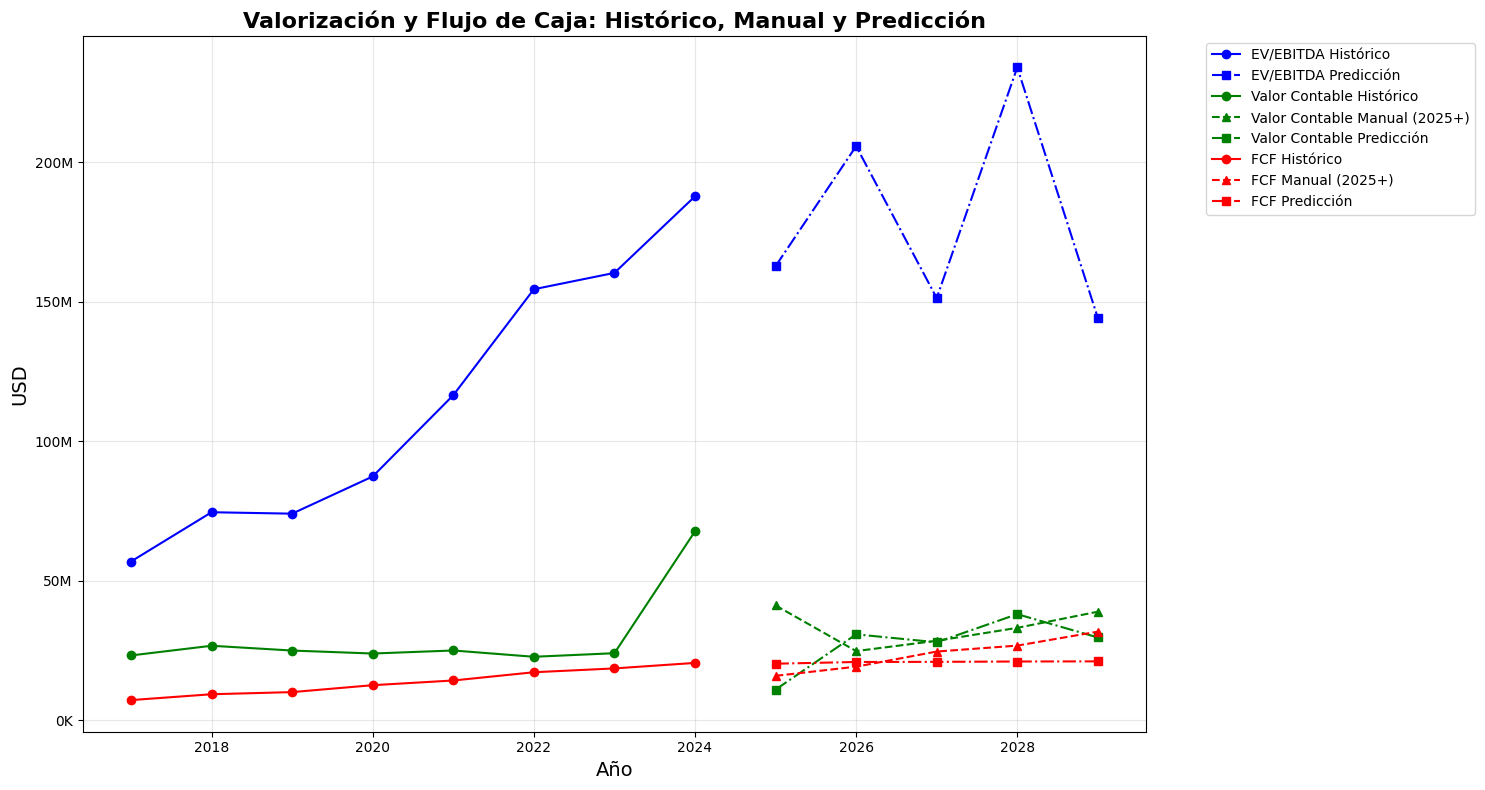


=== RESUMEN DE VALORIZACIÓN ===
Múltiplo EV/EBITDA usado: 8x

Años históricos: [2017 2018 2019 2020 2021 2022 2023 2024]
EV/EBITDA histórico: [ 56864000  74528000  74016000  87352000 116480000 154472000 160336000
 187784000]
EV/EBITDA predicción: [1.6274490e+08 2.0577229e+08 1.5131362e+08 2.3398387e+08 1.4418194e+08]

Valor contable histórico: [23186000 26657000 24941000 23874000 24962000 22709000 23988000 67678000]
Valor contable manual (2025+): [41126473 24749357 28448298 33078448 38865011]
Valor contable predicción: [10930858. 30748188. 27907654. 37985996. 29626934.]

FCF histórico: [ 7179000  9276000 10041000 12524000 14207000 17160000 18537000 20510000]
FCF manual (2025+): [15876000.  19157598.  24580639.6 26712164.  31721765.4]
FCF predicción: [20222590. 20840458. 20889068. 21011834. 21063094.]

=== FIN ===


In [16]:
# === MONTAJE DE GOOGLE DRIVE ===
from google.colab import drive
drive.mount('/content/drive')

# === IMPORTACIÓN DE LIBRERÍAS ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# === RUTA A TU CARPETA EN GOOGLE DRIVE ===
ruta_base = '/content/drive/MyDrive/Colab Notebooks'  # Cambia esto si tu carpeta tiene otro nombre

# === PARÁMETROS ===
MULTIPLO_EBITDA = 8
LOOK_BACK = 3
EPOCHS = 500

print("=== VALORIZACIÓN Y FLUJO DE CAJA ===\n")

# === 1. CARGAR DATOS HISTÓRICOS ===
df_resultados = pd.read_csv(f'{ruta_base}/tabla_estados_F_2017.csv', index_col=0).T
df_balance = pd.read_csv(f'{ruta_base}/AVGO_Balance_2017_2024.csv', index_col=0).T
df_flujo = pd.read_csv(f'{ruta_base}/AVGO_Estado_Flujo_Efectivo_2017_2024.csv', index_col=0).T

for df in [df_resultados, df_balance, df_flujo]:
    df.index = df.index.astype(str).str[:4].astype(int)
    df.sort_index(inplace=True)

# === 2. CARGAR PROYECCIONES MANUALES ===
df_resultados_man = pd.read_csv(f'{ruta_base}/estado_resultados_proyecciones.csv', index_col=0).T
df_balance_man = pd.read_csv(f'{ruta_base}/estado_situacion_financiera_proyecciones.csv', index_col=0).T

for df in [df_resultados_man, df_balance_man]:
    df.index = df.index.astype(int)
    df.sort_index(inplace=True)

# === 3. FUNCIÓN DE PREDICCIÓN CON LSTM ===
def pred_lstm(serie, look_back=LOOK_BACK, epochs=EPOCHS):
    datos = np.array(serie).reshape(-1, 1)
    scaler = MinMaxScaler()
    datos_escalados = scaler.fit_transform(datos)
    X, y = [], []
    for i in range(look_back, len(datos_escalados)):
        X.append(datos_escalados[i-look_back:i])
        y.append(datos_escalados[i])
    X, y = np.array(X), np.array(y)
    if len(X) < 2:
        return [np.nan]*5
    model = Sequential([
        LSTM(32, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
        Dropout(0.1),
        LSTM(16, return_sequences=False),
        Dropout(0.1),
        Dense(8),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
    model.fit(X, y, epochs=epochs, batch_size=1, verbose=0)
    ultimos = datos_escalados[-look_back:].reshape(1, look_back, 1)
    preds = []
    for _ in range(5):
        pred = model.predict(ultimos, verbose=0)[0,0]
        preds.append(pred)
        ultimos = np.roll(ultimos, -1, axis=1)
        ultimos[0, -1, 0] = pred
    return scaler.inverse_transform(np.array(preds).reshape(-1,1)).flatten()

# === 4. EV/EBITDA ===
ebitda_hist = df_resultados['EBITDA'].values
anios_hist = df_resultados.index.values
ebitda_pred = pred_lstm(ebitda_hist, epochs=EPOCHS)
anios_pred = np.arange(anios_hist[-1]+1, anios_hist[-1]+6)
ev_hist = ebitda_hist * MULTIPLO_EBITDA
ev_pred = ebitda_pred * MULTIPLO_EBITDA

ev_man = None
anios_man = None
if 'EBITDA' in df_resultados_man.columns:
    mask_man = df_resultados_man.index >= 2025
    ebitda_man = df_resultados_man.loc[mask_man, 'EBITDA'].values
    anios_man = df_resultados_man.index[mask_man].values
    ev_man = ebitda_man * MULTIPLO_EBITDA

# === 5. VALOR CONTABLE ===
act_hist = df_balance['Total activos'].values
pas_hist = df_balance['Total pasivos'].values
vc_hist = act_hist - pas_hist
vc_pred = pred_lstm(vc_hist, epochs=EPOCHS)
anios_vc_pred = np.arange(anios_hist[-1]+1, anios_hist[-1]+6)
vc_man = None
anios_vc_man = None
if 'TOTAL ACTIVOS/' in df_balance_man.columns and 'Total Pasivos/' in df_balance_man.columns:
    mask_vc_man = df_balance_man.index >= 2025
    act_man = df_balance_man.loc[mask_vc_man, 'TOTAL ACTIVOS/'].values
    pas_man = df_balance_man.loc[mask_vc_man, 'Total Pasivos/'].values
    anios_vc_man = df_balance_man.index[mask_vc_man].values
    vc_man = act_man - pas_man

# === 6. FCF ===
fc_oper = df_flujo['Flujo Neto de Operación'].values
capex = -df_flujo['Cambio Neto en Propiedad, Planta y Equipo'].values
fcf_hist = fc_oper + capex
fcf_pred = pred_lstm(fcf_hist, epochs=EPOCHS)
anios_fcf_pred = np.arange(anios_hist[-1]+1, anios_hist[-1]+6)
fcf_man = None
anios_fcf_man = None
if 'Flujo de caja libre (FCF)' in df_resultados_man.columns:
    mask_fcf_man = df_resultados_man.index >= 2025
    fcf_man = df_resultados_man.loc[mask_fcf_man, 'Flujo de caja libre (FCF)'].values
    anios_fcf_man = df_resultados_man.index[mask_fcf_man].values

# === 7. GRÁFICO ===
plt.figure(figsize=(15, 8))

# EV/EBITDA
plt.plot(anios_hist, ev_hist, 'b-o', label='EV/EBITDA Histórico')
if ev_man is not None:
    plt.plot(anios_man, ev_man, 'b--^', label='EV/EBITDA Manual (2025+)')
plt.plot(anios_pred, ev_pred, 'b-.s', label='EV/EBITDA Predicción')

# Valor contable
plt.plot(anios_hist, vc_hist, 'g-o', label='Valor Contable Histórico')
if vc_man is not None:
    plt.plot(anios_vc_man, vc_man, 'g--^', label='Valor Contable Manual (2025+)')
plt.plot(anios_vc_pred, vc_pred, 'g-.s', label='Valor Contable Predicción')

# FCF
plt.plot(anios_hist, fcf_hist, 'r-o', label='FCF Histórico')
if fcf_man is not None:
    plt.plot(anios_fcf_man, fcf_man, 'r--^', label='FCF Manual (2025+)')
plt.plot(anios_fcf_pred, fcf_pred, 'r-.s', label='FCF Predicción')

plt.title('Valorización y Flujo de Caja: Histórico, Manual y Predicción', fontsize=16, fontweight='bold')
plt.xlabel('Año', fontsize=14)
plt.ylabel('USD', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.0f}M' if x >= 1e6 else f'{x/1e3:.0f}K'))
plt.tight_layout()
plt.show()

# === 8. CONSOLA DE RESUMEN ===
print("\n=== RESUMEN DE VALORIZACIÓN ===")
print(f"Múltiplo EV/EBITDA usado: {MULTIPLO_EBITDA}x")
print("\nAños históricos:", anios_hist)
print("EV/EBITDA histórico:", ev_hist)
if ev_man is not None:
    print("EV/EBITDA manual (2025+):", ev_man)
print("EV/EBITDA predicción:", ev_pred)
print("\nValor contable histórico:", vc_hist)
if vc_man is not None:
    print("Valor contable manual (2025+):", vc_man)
print("Valor contable predicción:", vc_pred)
print("\nFCF histórico:", fcf_hist)
if fcf_man is not None:
    print("FCF manual (2025+):", fcf_man)
print("FCF predicción:", fcf_pred)
print("\n=== FIN ===")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
=== PREDICCIÓN DE RATIOS FINANCIEROS ===



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



ROA - DEVOLUCIÓN DE ACTIVOS (2017-2029):
  2017: 3.2894 
  2018: 25.1950 
  2019: 4.0538 
  2020: 3.8995 
  2021: 8.9136 
  2022: 15.6931 
  2023: 19.3272 
  2024: 3.7236 
  2025: 7.0078 (Pred)
  2026: 8.9082 (Pred)
  2027: 17.6723 (Pred)
  2028: 11.5821 (Pred)
  2029: 4.8186 (Pred)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



ROE - RETORNO DE LA EQUIDAD (2017-2029):
  2017: 7.7202 
  2018: 47.3759 
  2019: 10.9699 
  2020: 12.4026 
  2021: 26.9850 
  2022: 50.6187 
  2023: 58.7044 
  2024: 9.1137 
  2025: 28.2074 (Pred)
  2026: 28.5133 (Pred)
  2027: 46.7413 (Pred)
  2028: 51.4547 (Pred)
  2029: 9.8390 (Pred)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



MARGEN BRUTO (2017-2029):
  2017: 48.2479 
  2018: 51.4822 
  2019: 55.2419 
  2020: 56.5807 
  2021: 61.3625 
  2022: 66.5452 
  2023: 68.9299 
  2024: 63.0337 
  2025: 62.1754 (Pred)
  2026: 62.1711 (Pred)
  2027: 63.0161 (Pred)
  2028: 63.6206 (Pred)
  2029: 63.2973 (Pred)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



MARGEN OPERATIVO (2017-2029):
  2017: 13.4441 
  2018: 24.6307 
  2019: 15.2410 
  2020: 16.8034 
  2021: 31.0346 
  2022: 42.8425 
  2023: 45.2469 
  2024: 26.1042 
  2025: 25.2021 (Pred)
  2026: 20.1284 (Pred)
  2027: 27.8337 (Pred)
  2028: 35.9590 (Pred)
  2029: 41.9864 (Pred)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



FLUJO DE EFECTIVO OPERATIVO POR ACCIÓN (2017-2029):
  2017: 0.6655 
  2018: 0.5042 
  2019: 0.2540 
  2020: 0.5505 
  2021: 0.3436 
  2022: 0.7462 
  2023: 0.2788 
  2024: -0.0555 
  2025: 0.6974 (Pred)
  2026: 0.3239 (Pred)
  2027: 0.1978 (Pred)
  2028: 0.5787 (Pred)
  2029: 0.3682 (Pred)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



DEUDA A LARGO PLAZO /CAPITAL (2017-2029):
  2017: 0.4292 
  2018: 0.3962 
  2019: 0.5461 
  2020: 0.6276 
  2021: 0.6124 
  2022: 0.6324 
  2023: 0.6106 
  2024: 0.4948 
  2025: 0.5359 (Pred)
  2026: 0.6612 (Pred)
  2027: 0.6129 (Pred)
  2028: 0.6288 (Pred)
  2029: 0.6324 (Pred)


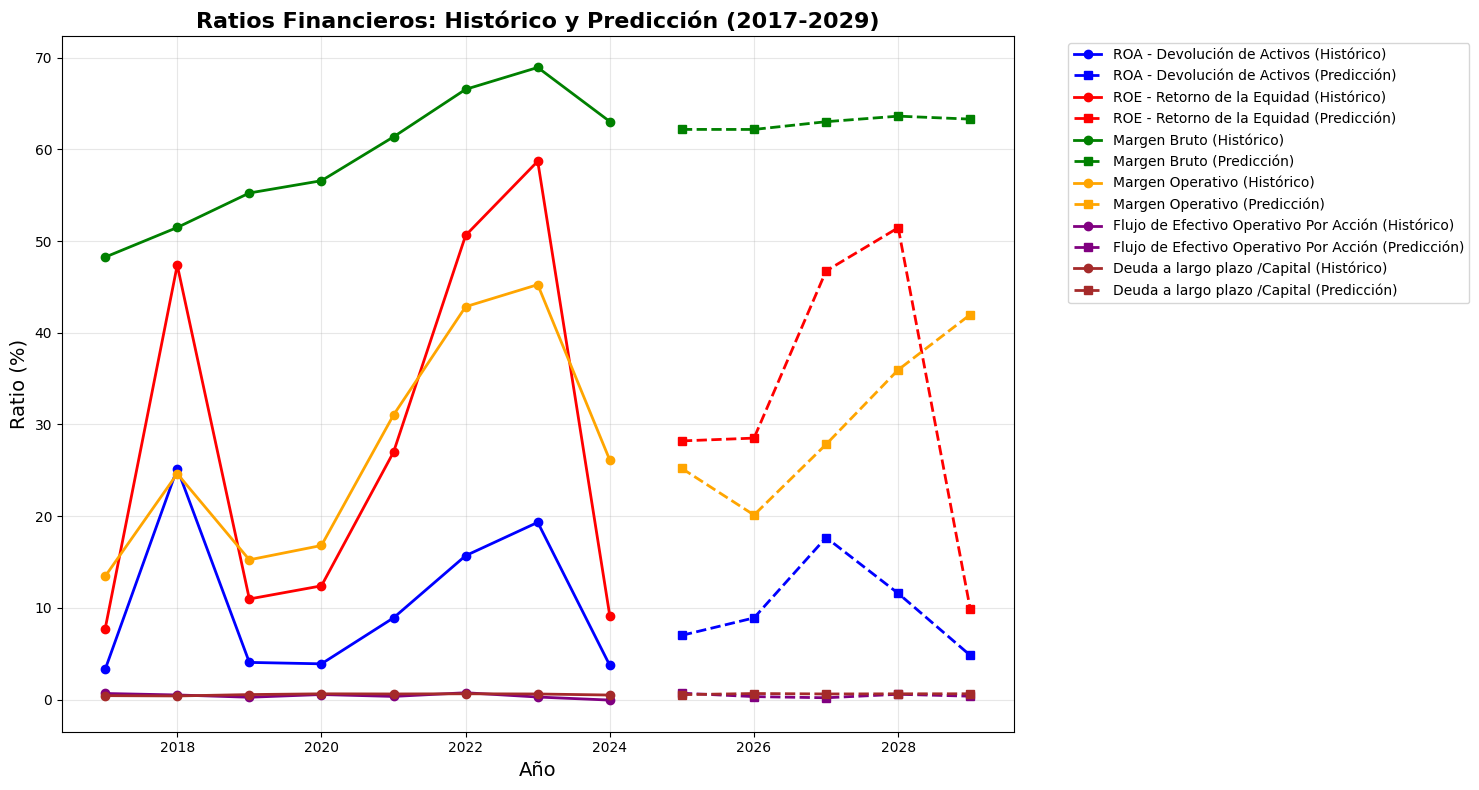


=== FIN ===


In [17]:
# === MONTAJE DE GOOGLE DRIVE ===
from google.colab import drive
drive.mount('/content/drive')

# === IMPORTACIÓN DE LIBRERÍAS ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# === CONFIGURACIÓN GENERAL ===
LOOK_BACK = 3
EPOCHS = 500
ruta_base = '/content/drive/MyDrive/Colab Notebooks'  # Cambia esta ruta si tu carpeta es diferente

# === LISTA DE RATIOS A PREDECIR ===
ratios = [
    'ROA - Devolución de Activos',
    'ROE - Retorno de la Equidad',
    'Margen Bruto',
    'Margen Operativo',
    'Flujo de Efectivo Operativo Por Acción',
    'Deuda a largo plazo /Capital'
]

print("=== PREDICCIÓN DE RATIOS FINANCIEROS ===\n")

# === 1. CARGAR DATOS ===
df = pd.read_csv(f'{ruta_base}/Ratios_Financieros_2017.csv', index_col=0).T
anios_hist = df.index.astype(int)
sort_idx = np.argsort(anios_hist)
anios_hist = anios_hist[sort_idx]
df = df.iloc[sort_idx]

# === 2. FUNCIÓN DE PREDICCIÓN ===
def pred_lstm(serie, look_back=LOOK_BACK, epochs=EPOCHS):
    datos = np.array(serie).reshape(-1, 1)
    scaler = MinMaxScaler()
    datos_escalados = scaler.fit_transform(datos)
    X, y = [], []
    for i in range(look_back, len(datos_escalados)):
        X.append(datos_escalados[i-look_back:i])
        y.append(datos_escalados[i])
    X, y = np.array(X), np.array(y)
    if len(X) < 2:
        return [np.nan]*5
    model = Sequential([
        LSTM(32, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
        Dropout(0.1),
        LSTM(16, return_sequences=False),
        Dropout(0.1),
        Dense(8),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
    model.fit(X, y, epochs=epochs, batch_size=1, verbose=0)
    ultimos = datos_escalados[-look_back:].reshape(1, look_back, 1)
    preds = []
    for _ in range(5):
        pred = model.predict(ultimos, verbose=0)[0,0]
        preds.append(pred)
        ultimos = np.roll(ultimos, -1, axis=1)
        ultimos[0, -1, 0] = pred
    return scaler.inverse_transform(np.array(preds).reshape(-1,1)).flatten()

# === 3. PREDICCIÓN Y GRÁFICO ===
plt.figure(figsize=(15, 8))
colores = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
marcadores = ['o', 's', '^', 'D', 'v', 'x']

for i, ratio in enumerate(ratios):
    if ratio not in df.columns:
        print(f"❌ No encontrado en CSV: {ratio}")
        continue
    serie_hist = df[ratio].values
    pred = pred_lstm(serie_hist)
    anios_pred = np.arange(anios_hist[-1]+1, anios_hist[-1]+6)
    serie_total = np.concatenate([serie_hist, pred])
    anios_total = np.concatenate([anios_hist, anios_pred])
    print(f"\n{ratio.upper()} (2017-2029):")
    for a, v in zip(anios_total, serie_total):
        tipo = "(Pred)" if a >= 2025 else ""
        print(f"  {a}: {v:.4f} {tipo}")
    plt.plot(anios_hist, serie_hist, color=colores[i], marker=marcadores[0], linewidth=2, markersize=6, label=f'{ratio} (Histórico)')
    plt.plot(anios_pred, pred, color=colores[i], marker=marcadores[1], linewidth=2, markersize=6, linestyle='--', label=f'{ratio} (Predicción)')

plt.title('Ratios Financieros: Histórico y Predicción (2017-2029)', fontsize=16, fontweight='bold')
plt.xlabel('Año', fontsize=14)
plt.ylabel('Ratio (%)', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n=== FIN ===")


Mounted at /content/drive
=== VALORIZACIÓN POR DCF (Flujo de Caja Descontado) ===



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


FCF histórico (2017-2024): [ 7179000  9276000 10041000 12524000 14207000 17160000 18537000 20510000]
FCF predicción (2025-2029): [21725776. 21897050. 22042332. 22095718. 22086892.]

Deuda total (D): 66,295,000
Patrimonio (E): 67,678,000
Acciones en circulación: 4,778,000
Tasa impositiva efectiva (t): 37.80%
Costo de la deuda (K_d): 6.00%
Costo del capital (K_e): 12.00%
Crecimiento perpetuo (g): 3.00%
WACC: 7.91%

Valor presente de FCF proyectados: 87,872,416
Valor residual descontado: 316,750,753
Valor Empresa (EV): 404,623,169

Valor del Capital: 338,328,169
Valor por Acción: 70.81


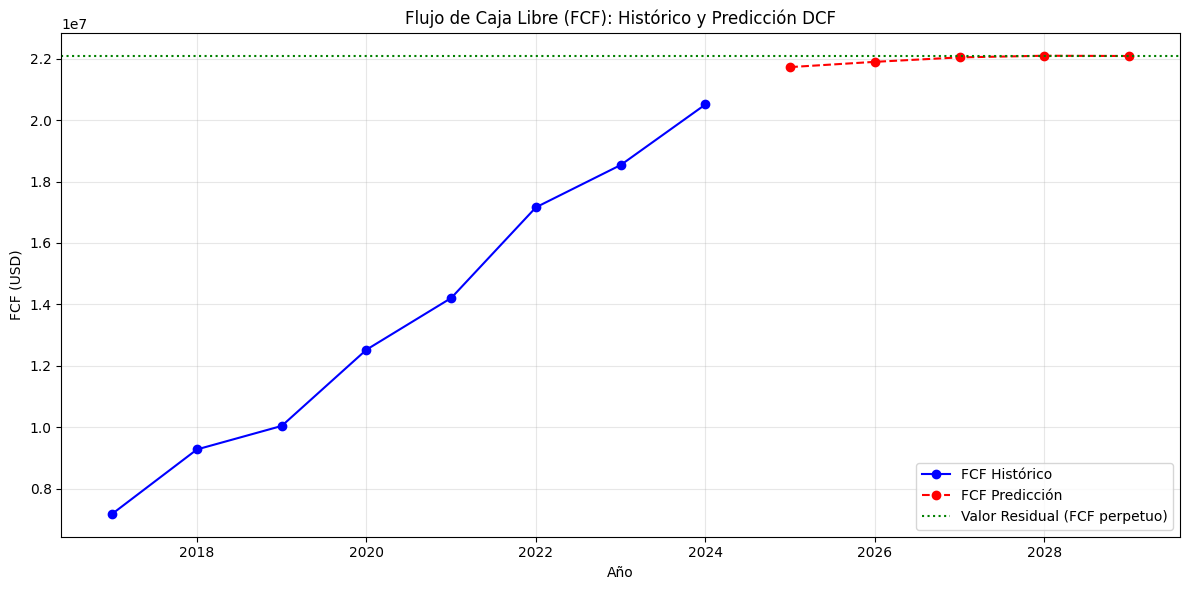


=== FIN ===


In [8]:
# MONTAJE DE GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')

# IMPORTACIONES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# CONSTANTES DCF
K_d = 0.06
K_e = 0.12
g = 0.03
n = 5

print("=== VALORIZACIÓN POR DCF (Flujo de Caja Descontado) ===\n")

# RUTAS A LOS ARCHIVOS (ajusta según tu Drive)
ruta_flujo = '/content/drive/MyDrive/Colab Notebooks/AVGO_Estado_Flujo_Efectivo_2017_2024.csv'
ruta_balance = '/content/drive/MyDrive/Colab Notebooks/AVGO_Balance_2017_2024.csv'
ruta_resultados = '/content/drive/MyDrive/Colab Notebooks/tabla_estados_F_2017.csv'

# CARGA DE DATOS
df_flujo = pd.read_csv(ruta_flujo, index_col=0).T
for df in [df_flujo]:
    df.index = df.index.astype(str).str[:4].astype(int)
    df.sort_index(inplace=True)

df_balance = pd.read_csv(ruta_balance, index_col=0).T
df_balance.index = df_balance.index.astype(str).str[:4].astype(int)
df_balance.sort_index(inplace=True)

df_resultados = pd.read_csv(ruta_resultados, index_col=0).T
df_resultados.index = df_resultados.index.astype(str).str[:4].astype(int)
df_resultados.sort_index(inplace=True)

# CÁLCULO DE FCF
fc_oper = df_flujo['Flujo Neto de Operación'].values
capex = -df_flujo['Cambio Neto en Propiedad, Planta y Equipo'].values
fcf_hist = fc_oper + capex
anios_hist = df_flujo.index.values

# PREDICCIÓN LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

LOOK_BACK = 3
EPOCHS = 500

def pred_lstm(serie, look_back=LOOK_BACK, epochs=EPOCHS):
    datos = np.array(serie).reshape(-1, 1)
    scaler = MinMaxScaler()
    datos_escalados = scaler.fit_transform(datos)
    X, y = [], []
    for i in range(look_back, len(datos_escalados)):
        X.append(datos_escalados[i-look_back:i])
        y.append(datos_escalados[i])
    X, y = np.array(X), np.array(y)
    if len(X) < 2:
        return [np.nan]*n
    model = Sequential([
        LSTM(32, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
        Dropout(0.1),
        LSTM(16, return_sequences=False),
        Dropout(0.1),
        Dense(8),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
    model.fit(X, y, epochs=epochs, batch_size=1, verbose=0)
    ultimos = datos_escalados[-look_back:].reshape(1, look_back, 1)
    preds = []
    for _ in range(n):
        pred = model.predict(ultimos, verbose=0)[0,0]
        preds.append(pred)
        ultimos = np.roll(ultimos, -1, axis=1)
        ultimos[0, -1, 0] = pred
    return scaler.inverse_transform(np.array(preds).reshape(-1,1)).flatten()

fcf_pred = pred_lstm(fcf_hist)
anios_pred = np.arange(anios_hist[-1]+1, anios_hist[-1]+n+1)

# RESULTADOS INTERMEDIOS
print(f"FCF histórico ({anios_hist[0]}-{anios_hist[-1]}): {fcf_hist}")
print(f"FCF predicción ({anios_pred[0]}-{anios_pred[-1]}): {fcf_pred}")

# DATOS FINANCIEROS PARA DCF
if 'Deuda a largo plazo' in df_balance.columns:
    D = df_balance['Deuda a largo plazo'].iloc[-1]
else:
    D = df_balance['Total pasivos'].iloc[-1]

if 'Patrimonio de los accionistas' in df_balance.columns:
    E = df_balance['Patrimonio de los accionistas'].iloc[-1]
else:
    E = df_balance['Total activos'].iloc[-1] - df_balance['Total pasivos'].iloc[-1]

if 'Acciones en Circulación' in df_resultados.columns:
    acciones = df_resultados['Acciones en Circulación'].iloc[-1]
else:
    acciones = 1

if 'Impuestos a la Renta' in df_resultados.columns and 'Utilidad Antes de Impuestos' in df_resultados.columns:
    impuestos = df_resultados['Impuestos a la Renta'].iloc[-1]
    util_antes_imp = df_resultados['Utilidad Antes de Impuestos'].iloc[-1]
    t = max(0, impuestos / util_antes_imp) if util_antes_imp != 0 else 0.25
else:
    t = 0.25

# CÁLCULO DEL VALOR
print(f"\nDeuda total (D): {D:,.0f}")
print(f"Patrimonio (E): {E:,.0f}")
print(f"Acciones en circulación: {acciones:,.0f}")
print(f"Tasa impositiva efectiva (t): {t:.2%}")
print(f"Costo de la deuda (K_d): {K_d:.2%}")
print(f"Costo del capital (K_e): {K_e:.2%}")
print(f"Crecimiento perpetuo (g): {g:.2%}")

WACC = (D/(D+E))*K_d*(1-t) + (E/(D+E))*K_e
print(f"WACC: {WACC:.2%}")

ev = 0
for i, fcf in enumerate(fcf_pred):
    ev += fcf / (1 + WACC)**(i+1)
fcf_n1 = fcf_pred[-1] * (1 + g)
vr = fcf_n1 / (WACC - g)
vr_desc = vr / (1 + WACC)**n
ev += vr_desc
print(f"\nValor presente de FCF proyectados: {ev - vr_desc:,.0f}")
print(f"Valor residual descontado: {vr_desc:,.0f}")
print(f"Valor Empresa (EV): {ev:,.0f}")

deuda_neta = D
valor_capital = ev - deuda_neta
valor_accion = valor_capital / acciones if acciones > 0 else np.nan
print(f"\nValor del Capital: {valor_capital:,.0f}")
print(f"Valor por Acción: {valor_accion:,.2f}")

# GRAFICAR
plt.figure(figsize=(12,6))
plt.plot(anios_hist, fcf_hist, 'bo-', label='FCF Histórico')
plt.plot(anios_pred, fcf_pred, 'ro--', label='FCF Predicción')
plt.axhline(y=fcf_pred[-1], color='green', linestyle=':', label='Valor Residual (FCF perpetuo)')
plt.title('Flujo de Caja Libre (FCF): Histórico y Predicción DCF')
plt.xlabel('Año')
plt.ylabel('FCF (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n=== FIN ===")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
=== PREDICCIÓN Y TABLA DE FLUJO DE CAJA Y RESULTADOS ===

[DEBUG] Ingresos - Serie histórica: [17636000 20848000 22597000 23888000 27450000 33203000 35819000 51574000]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[DEBUG] Ingresos - Predicción LSTM: [6.9571568e+07 8.3123960e+07 9.5207000e+07 9.9767400e+07 1.0147837e+08]

INGRESOS (2017-2029):
Año         Histórico     Predicción         Manual
2017    51,574,000.00                              
2018    35,819,000.00                              
2019    33,203,000.00                              
2020    27,450,000.00                              
2021    23,888,000.00                              
2022    22,597,000.00                              
2023    20,848,000.00                              
2024    17,636,000.00                              
2025                   69,571,568.00  64,093,000.00
2026                   83,123,960.00  79,651,000.00
2027                   95,207,000.00  98,985,740.00
2028                   99,767,400.00 123,013,200.00
2029                  101,478,368.00 152,873,400.00
[DEBUG] Costo de Ventas - Serie histórica: [ 9127000 10115000 10114000 10372000 10606000 11108000 11129000 19065000]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[DEBUG] Costo de Ventas - Predicción LSTM: [36815648. 46411424. 49206636. 49474252. 49492040.]

COSTO DE VENTAS (2017-2029):
Año         Histórico     Predicción         Manual
2017    19,065,000.00                              
2018    11,129,000.00                              
2019    11,108,000.00                              
2020    10,606,000.00                              
2021    10,372,000.00                              
2022    10,114,000.00                              
2023    10,115,000.00                              
2024     9,127,000.00                              
2025                   36,815,648.00  23,909,510.00
2026                   46,411,424.00  29,985,020.00
2027                   49,206,636.00  37,604,360.00
2028                   49,474,252.00  47,159,810.00
2029                   49,492,040.00  59,143,340.00
[DEBUG] Utilidad Bruta - Serie histórica: [ 8509000 10733000 12483000 13516000 16844000 22095000 24690000 32509000]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[DEBUG] Utilidad Bruta - Predicción LSTM: [35347564. 38034488. 40568100. 41385988. 42007752.]

UTILIDAD BRUTA (2017-2029):
Año         Histórico     Predicción         Manual
2017    32,509,000.00                              
2018    24,690,000.00                              
2019    22,095,000.00                              
2020    16,844,000.00                              
2021    13,516,000.00                              
2022    12,483,000.00                              
2023    10,733,000.00                              
2024     8,509,000.00                              
2025                   35,347,564.00  40,183,500.00
2026                   38,034,488.00  49,665,890.00
2027                   40,568,100.00  61,381,110.00
2028                   41,385,988.00  75,783,290.00
2029                   42,007,752.00  93,730,060.00
[DEBUG] Gastos SG&A - Serie histórica: [ 789000 1056000 1709000 1935000 1347000 1382000 1592000 4959000]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[DEBUG] Gastos SG&A - Predicción LSTM: [2138767.8 1821403.1 1633984.6 2050797.9 2169313.5]

GASTOS SG&A (2017-2029):
Año         Histórico     Predicción         Manual
2017     4,959,000.00                              
2018     1,592,000.00                              
2019     1,382,000.00                              
2020     1,347,000.00                              
2021     1,935,000.00                              
2022     1,709,000.00                              
2023     1,056,000.00                              
2024       789,000.00                              
2025                    2,138,767.75   3,828,488.00
2026                    1,821,403.12   6,656,282.00
2027                    1,633,984.62   9,175,796.00
2028                    2,050,797.88  12,639,484.00
2029                    2,169,313.50  17,437,870.00
[DEBUG] Utilidad Operativa - Serie histórica: [ 2371000  5135000  3444000  4014000  8519000 14225000 16207000 13463000]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[DEBUG] Utilidad Operativa - Predicción LSTM: [13528919. 14966178. 15486630. 14992200. 14931917.]

UTILIDAD OPERATIVA (2017-2029):
Año         Histórico     Predicción         Manual
2017    13,463,000.00                              
2018    16,207,000.00                              
2019    14,225,000.00                              
2020     8,519,000.00                              
2021     4,014,000.00                              
2022     3,444,000.00                              
2023     5,135,000.00                              
2024     2,371,000.00                              
2025                   13,528,919.00  15,581,500.00
2026                   14,966,178.00  22,994,980.00
2027                   15,486,630.00  32,125,430.00
2028                   14,992,200.00  35,212,220.00
2029                   14,931,917.00  43,450,070.00
[DEBUG] Depreciación y Amortización - Serie histórica: [ 4737000  4081000  4051000  6905000  6041000  4984000  3835000 10010000]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[DEBUG] Depreciación y Amortización - Predicción LSTM: [5817699.5 4850005.5 5384790.  7307049.  5845398.5]

DEPRECIACIÓN Y AMORTIZACIÓN (2017-2029):
Año         Histórico     Predicción         Manual
2017    10,010,000.00                              
2018     3,835,000.00                              
2019     4,984,000.00                              
2020     6,041,000.00                              
2021     6,905,000.00                              
2022     4,051,000.00                              
2023     4,081,000.00                              
2024     4,737,000.00                              
2025                    5,817,699.50     760,187.00
2026                    4,850,005.50     822,612.00
2027                    5,384,790.00     890,162.80
2028                    7,307,049.00     963,260.60
2029                    5,845,398.50   1,042,361.00
[DEBUG] Impuestos a la Renta - Serie histórica: [   35000 -8084000  -510000  -518000    29000   939000  1015000  3748000]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[DEBUG] Impuestos a la Renta - Predicción LSTM: [ 5089207.  8633953. 15773589. 22339980. 28947882.]

IMPUESTOS A LA RENTA (2017-2029):
Año         Histórico     Predicción         Manual
2017     3,748,000.00                              
2018     1,015,000.00                              
2019       939,000.00                              
2020        29,000.00                              
2021      -518,000.00                              
2022      -510,000.00                              
2023    -8,084,000.00                              
2024        35,000.00                              
2025                    5,089,207.00   3,641,530.00
2026                    8,633,953.00   5,748,328.00
2027                   15,773,589.00   7,118,849.00
2028                   22,339,980.00   8,816,422.00
2029                   28,947,882.00  10,918,290.00
[DEBUG] Flujo Neto de Operación - Serie histórica: [ 6551000  8880000  9697000 12061000 13764000 16736000 18085000 19962000]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[DEBUG] Flujo Neto de Operación - Predicción LSTM: [21409460. 22089664. 22597842. 22887790. 23036392.]

FLUJO NETO DE OPERACIÓN (2017-2029):
Año         Histórico     Predicción         Manual
2017    19,962,000.00                              
2018    18,085,000.00                              
2019    16,736,000.00                              
2020    13,764,000.00                              
2021    12,061,000.00                              
2022     9,697,000.00                              
2023     8,880,000.00                              
2024     6,551,000.00                              
2025                   21,409,460.00  19,117,657.00
2026                   22,089,664.00  23,772,552.00
2027                   22,597,842.00  28,914,120.86
2028                   22,887,790.00  36,085,930.60
2029                   23,036,392.00  44,942,391.43
[DEBUG] Cambio Neto en Propiedad, Planta y Equipo - Serie histórica: [-628000 -396000 -344000 -463000 -443000 -424000 -452000 -5480

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[DEBUG] Cambio Neto en Propiedad, Planta y Equipo - Predicción LSTM: [-512433.56 -500621.44 -479570.53 -483503.88 -487298.16]

CAMBIO NETO EN PROPIEDAD, PLANTA Y EQUIPO (2017-2029):
Año         Histórico     Predicción         Manual
2017      -548,000.00                              
2018      -452,000.00                              
2019      -424,000.00                              
2020      -443,000.00                              
2021      -463,000.00                              
2022      -344,000.00                              
2023      -396,000.00                              
2024      -628,000.00                              
2025                     -512,433.56     567,285.00
2026                     -500,621.44     624,245.00
2027                     -479,570.53     675,508.00
2028                     -483,503.88     730,500.00
2029                     -487,298.16     791,004.00
[DEBUG] Total Cambio en Activos/Pasivos - Serie histórica: [ -986000  -956000  -184000  10

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[DEBUG] Total Cambio en Activos/Pasivos - Predicción LSTM: [-3687174.2 -5129291.  -1201022.5  4355496.5 14725761. ]

TOTAL CAMBIO EN ACTIVOS/PASIVOS (2017-2029):
Año         Histórico     Predicción         Manual
2017    -4,637,000.00                              
2018    -1,643,000.00                              
2019    -1,654,000.00                              
2020      -127,000.00                              
2021     1,093,000.00                              
2022      -184,000.00                              
2023      -956,000.00                              
2024      -986,000.00                              
2025                   -3,687,174.25   2,724,000.00
2026                   -5,129,291.00   3,990,079.00
2027                   -1,201,022.50   3,538,023.28
2028                    4,355,496.50   8,523,124.00
2029                   14,725,761.00  12,429,662.00
[DEBUG] FCF - Serie histórica: [ 6193000  8320000  9857000 13617000 14080000 15506000 16894000 15873000]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[DEBUG] FCF - Predicción LSTM: [16393864. 16489126. 16415268. 16468779. 16475019.]

FCF (2017-2029):
Año         Histórico     Predicción         Manual
2017    15,873,000.00                              
2018    16,894,000.00                              
2019    15,506,000.00                              
2020    14,080,000.00                              
2021    13,617,000.00                              
2022     9,857,000.00                              
2023     8,320,000.00                              
2024     6,193,000.00                              
2025                   16,393,864.00  15,876,000.00
2026                   16,489,126.00  19,157,598.00
2027                   16,415,268.00  24,580,639.60
2028                   16,468,779.00  26,712,164.00
2029                   16,475,019.00  31,721,765.40


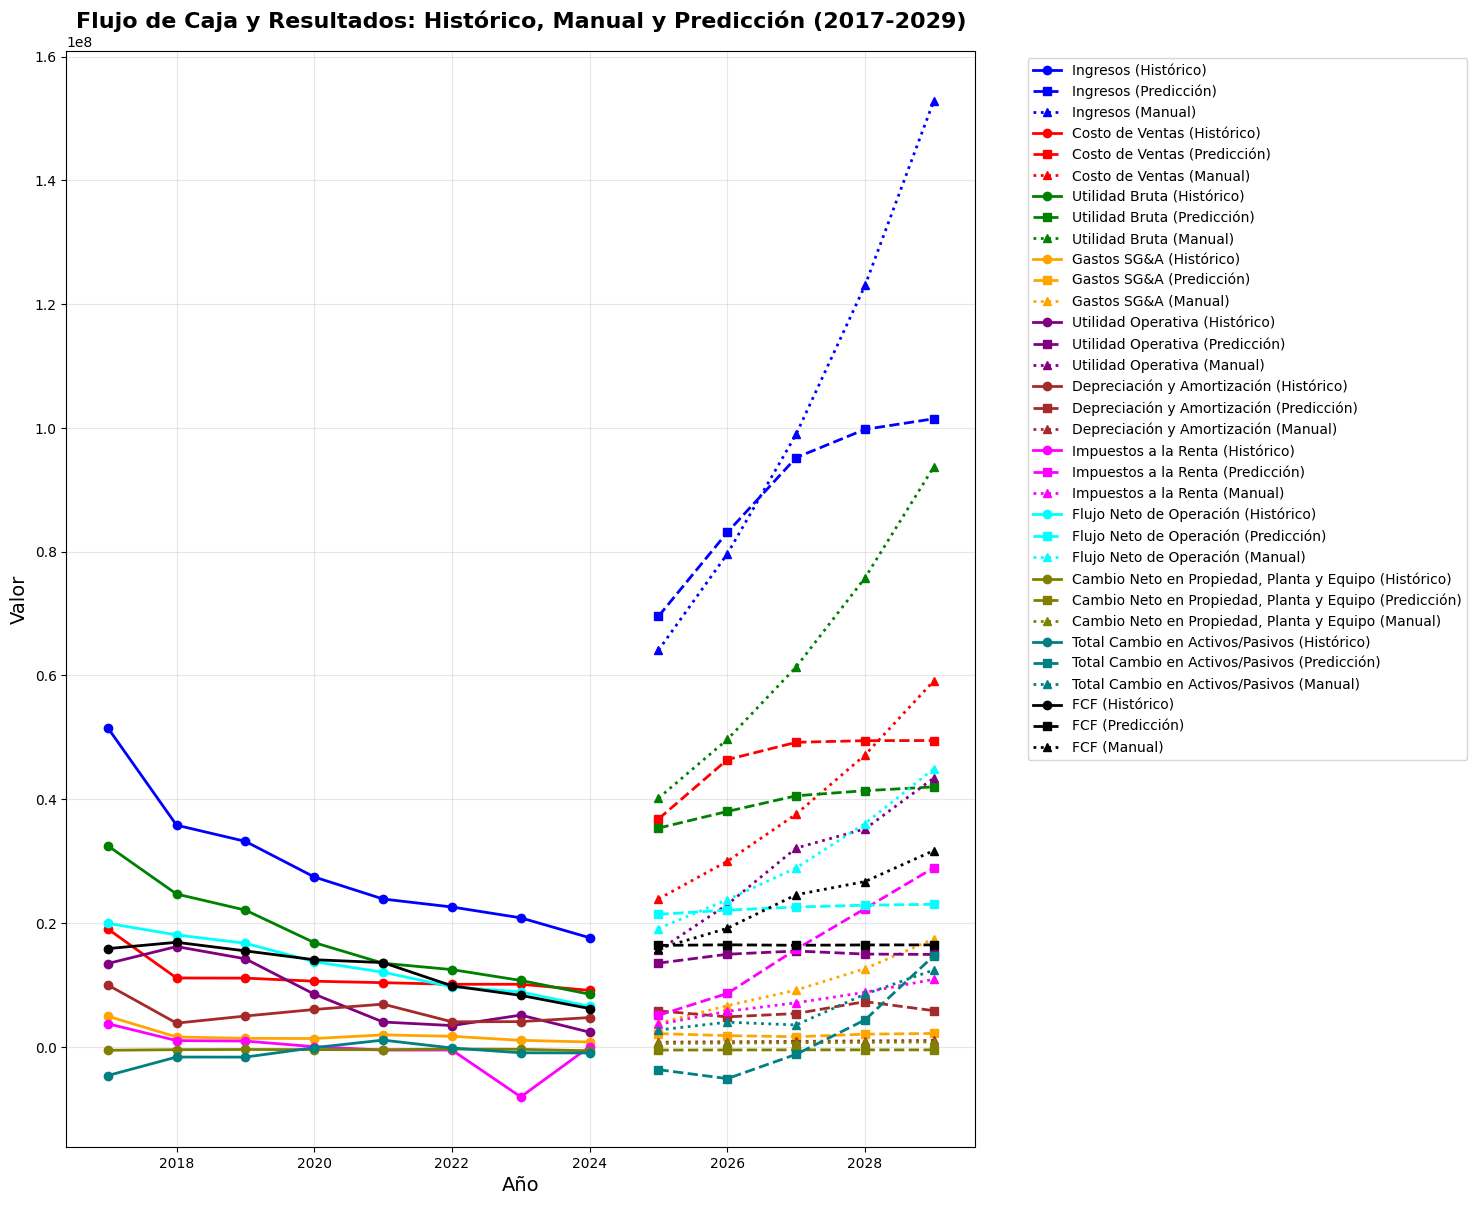


=== FIN ===


In [19]:
# === 0. MONTAJE DE GOOGLE DRIVE ===
from google.colab import drive
drive.mount('/content/drive')

# === 1. LIBRERÍAS ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

LOOK_BACK = 3
EPOCHS = 200

# === 2. MÉTRICAS ===
metricas = [
    ('Ingresos', 'Ingresos de actividades ordinarias'),
    ('Costo de Ventas', 'Costos de ventas'),
    ('Utilidad Bruta', 'Ganancia (pérdida) bruta'),
    ('Gastos SG&A', 'Gastos de ventas y distribución y Gastos de administración'),
    ('Utilidad Operativa', 'Ganancia (pérdida) operativa'),
    ('Depreciación y Amortización', 'Gastos de depreciación y amortización'),
    ('Impuestos a la Renta', '(Gasto) por impuesto a la renta'),
    ('Flujo Neto de Operación', 'Flujo de caja bruto'),
    ('Cambio Neto en Propiedad, Planta y Equipo', 'Inversiones en activos fijos neto'),
    ('Total Cambio en Activos/Pasivos', 'Variaciones en capital de trabajo'),
    ('FCF', 'Flujo de caja libre (FCF)')
]

print("=== PREDICCIÓN Y TABLA DE FLUJO DE CAJA Y RESULTADOS ===\n")

# === 3. CARGA DE DATOS DESDE GOOGLE DRIVE ===
ruta_base = '/content/drive/MyDrive/Colab Notebooks/'  # <-- Ajusta esta ruta si tu carpeta tiene otro nombre

df_res = pd.read_csv(ruta_base + 'tabla_estados_F_2017.csv', index_col=0).T
anios_hist = df_res.index.astype(int)
df_res = df_res.sort_index()

df_flujo = pd.read_csv(ruta_base + 'AVGO_Estado_Flujo_Efectivo_2017_2024.csv', index_col=0).T
anios_flujo = df_flujo.index.astype(int)
df_flujo = df_flujo.sort_index()

df_man = pd.read_csv(ruta_base + 'estado_resultados_proyecciones.csv', index_col=0).T
anios_man = df_man.index.astype(int)
df_man = df_man.sort_index()

# === 4. FUNCIÓN LSTM ===
def pred_lstm(serie, look_back=LOOK_BACK, epochs=EPOCHS):
    datos = np.array(serie).reshape(-1, 1)
    scaler = MinMaxScaler()
    datos_escalados = scaler.fit_transform(datos)
    X, y = [], []
    for i in range(look_back, len(datos_escalados)):
        X.append(datos_escalados[i-look_back:i])
        y.append(datos_escalados[i])
    X, y = np.array(X), np.array(y)
    if len(X) < 2:
        return [np.nan]*5
    model = Sequential([
        LSTM(32, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
        Dropout(0.1),
        LSTM(16, return_sequences=False),
        Dropout(0.1),
        Dense(8),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
    model.fit(X, y, epochs=epochs, batch_size=1, verbose=0)
    ultimos = datos_escalados[-look_back:].reshape(1, look_back, 1)
    preds = []
    for _ in range(5):
        pred = model.predict(ultimos, verbose=0)[0,0]
        preds.append(pred)
        ultimos = np.roll(ultimos, -1, axis=1)
        ultimos[0, -1, 0] = pred
    return scaler.inverse_transform(np.array(preds).reshape(-1,1)).flatten()

# === 5. PREDICCIÓN Y VISUALIZACIÓN ===
plt.figure(figsize=(15, 12))
colores = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'magenta', 'cyan', 'olive', 'teal', 'black']
marcadores = ['o', 's', '^', 'D', 'v', 'x', '*', 'P', 'h', '+', '1']

for i, (col_hist, col_man) in enumerate(metricas):
    if col_hist in df_res.columns:
        serie_hist = df_res[col_hist].values
        anios_hist_local = anios_hist.values if hasattr(anios_hist, 'values') else anios_hist
    elif col_hist in df_flujo.columns:
        serie_hist = df_flujo[col_hist].values
        anios_hist_local = anios_flujo.values if hasattr(anios_flujo, 'values') else anios_flujo
    elif col_hist == 'FCF':
        if 'Flujo Neto de Operación' in df_flujo.columns and 'Cambio Neto en Propiedad, Planta y Equipo' in df_flujo.columns and 'Total Cambio en Activos/Pasivos' in df_flujo.columns:
            serie_hist = df_flujo['Flujo Neto de Operación'].values + (-df_flujo['Cambio Neto en Propiedad, Planta y Equipo'].values) + df_flujo['Total Cambio en Activos/Pasivos'].values
            anios_hist_local = anios_flujo.values if hasattr(anios_flujo, 'values') else anios_flujo
        else:
            serie_hist = np.array([np.nan]*len(anios_hist))
            anios_hist_local = anios_hist.values if hasattr(anios_hist, 'values') else anios_hist
    else:
        serie_hist = np.array([np.nan]*len(anios_hist))
        anios_hist_local = anios_hist.values if hasattr(anios_hist, 'values') else anios_hist

    print(f"[DEBUG] {col_hist} - Serie histórica:", serie_hist)
    pred = pred_lstm(serie_hist)
    print(f"[DEBUG] {col_hist} - Predicción LSTM:", pred)

    if len(anios_hist_local) > 0:
        orden = np.argsort(anios_hist_local)
        anios_hist_local = np.array(anios_hist_local)[orden]
        serie_hist = np.array(serie_hist)[orden]
        mask_hist = (anios_hist_local >= 2017) & (anios_hist_local <= 2024)
        anios_hist_local = anios_hist_local[mask_hist]
        serie_hist = serie_hist[mask_hist]

    anios_pred = np.arange(2025, 2030)

    if col_man in df_man.columns:
        serie_man = df_man[col_man].values
        anios_man_local = anios_man.values if hasattr(anios_man, 'values') else anios_man
    else:
        serie_man = None
        anios_man_local = None

    data = {}
    for a, v in zip(anios_hist_local, serie_hist):
        if a <= 2024:
            data[a] = {'Histórico': v, 'Predicción': None, 'Manual': None}
    for a, v in zip(anios_pred, pred):
        if 2025 <= a <= 2029:
            if a not in data:
                data[a] = {'Histórico': None, 'Predicción': v, 'Manual': None}
            else:
                if data[a].get('Predicción') is None:
                    data[a]['Predicción'] = v
    if serie_man is not None:
        for a, v in zip(anios_man_local, serie_man):
            if 2025 <= a <= 2029:
                if a not in data:
                    data[a] = {'Histórico': None, 'Predicción': None, 'Manual': v}
                else:
                    if data[a].get('Manual') is None:
                        data[a]['Manual'] = v

    anios_ordenados = sorted(data.keys())
    print(f"\n{col_hist.upper()} (2017-2029):")
    print(f"{'Año':<6}{'Histórico':>15}{'Predicción':>15}{'Manual':>15}")
    pred_vacia = True
    for a in anios_ordenados:
        h = data[a]['Histórico']
        p = data[a]['Predicción']
        m = data[a]['Manual']
        def fmt(x):
            return f"{x:,.2f}" if isinstance(x, (int, float, np.integer, np.floating)) and x is not None else ""
        if p is not None:
            pred_vacia = False
        print(f"{a:<6}{fmt(h):>15}{fmt(p):>15}{fmt(m):>15}")
    if pred_vacia:
        print("[ADVERTENCIA] No se generaron predicciones para 2025-2029. Revisa los datos históricos y la función de predicción.")

    vals_hist = [data[a]['Histórico'] if a <= 2024 else None for a in anios_ordenados]
    vals_pred = [data[a]['Predicción'] if 2025 <= a <= 2029 else None for a in anios_ordenados]
    vals_man = [data[a]['Manual'] if 2025 <= a <= 2029 else None for a in anios_ordenados]
    plt.plot(anios_ordenados, vals_hist, color=colores[i], marker=marcadores[0], linewidth=2, markersize=6, label=f'{col_hist} (Histórico)')
    plt.plot(anios_ordenados, vals_pred, color=colores[i], marker=marcadores[1], linewidth=2, markersize=6, linestyle='--', label=f'{col_hist} (Predicción)')
    if serie_man is not None:
        plt.plot(anios_ordenados, vals_man, color=colores[i], marker=marcadores[2], linewidth=2, markersize=6, linestyle=':', label=f'{col_hist} (Manual)')

plt.title('Flujo de Caja y Resultados: Histórico, Manual y Predicción (2017-2029)', fontsize=16, fontweight='bold')
plt.xlabel('Año', fontsize=14)
plt.ylabel('Valor', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n=== FIN ===")
